In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import glob
import random
import cv2
import albumentations as A # !pip install -U albumentations

from PIL import Image
import torchvision
import torchvision.transforms as transforms

/scratch/ipykernel_1293798/3213037383.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Working with Data

Training a DL Model requires us to convert the data into a format that can be processed by the model. For example the model might require images with a width of 512, and a height of 512, but the data we collected contains images with a width of 1280, and a height of 720. We therefore need a way to be able to convert the available data we have, into the exact format required by the model.

Or while working with very large datasets, it would be impractical to load the entire dataset into memory at once. We would need some way to be able index into the dataset, and load only the data we need at a given time.

## Loading Data in Pytorch

Working with datasets is pretty simple if you are using data that has implemented methods in Pytorch (Example: MNIST, CIFAR10, etc). However, if you are working with your own dataset, and it is not stored in a "specific" way, you will have to code a whole new class for your dataset.

Pytorch makes it easier to work with your own dataset by providing a class called `torch.utils.data.Dataset`. This class is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

* `__len__` - so that len(dataset) returns the size of the dataset.
* `__getitem__` - to support the indexing such that dataset[i] can be used to get i-th sample.

Additionally, use the `__init__` method to initialize/transform the dataset.

```
root
├── orange
│   ├── orange_image1.png
│   └── orange_image1.png
├── apple
│   └── apple_image1.png
│   └── apple_image2.png
│   └── apple_image3.png
```

If your dataset is of the above format, you're in luck! Pytorch provides a class called `torchvision.datasets.ImageFolder` which is a generic data loader that loads images from a directory. It assumes that images are organized in the following way:

* Each class has its own directory
* Each image is stored in it's class directory

In [2]:
dataset = torchvision.datasets.ImageFolder(root='/projectnb/ds598/materials/datasets/toy_dataset',
                                            transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                ]))
# 1. Number of Images
print(f"Total number of images: {len(dataset)}")

# 2. Classes
print(f"Classes: {dataset.classes}")

# 3. Class-to-Index Mapping
print(f"Class-to-Index Mapping: {dataset.class_to_idx}")

# 4. Sample Image Paths and Labels (printing first 5 for brevity)
for i, (path, label) in enumerate(dataset.samples[:5]):
    print(f"Image {i+1}: Path: {path}, Label: {label}")

# 5. Transformations
print(f"Transformations: {dataset.transform}")


Total number of images: 4
Classes: ['apple', 'orange']
Class-to-Index Mapping: {'apple': 0, 'orange': 1}
Image 1: Path: /projectnb/ds598/materials/datasets/toy_dataset/apple/apple_1.jpeg, Label: 0
Image 2: Path: /projectnb/ds598/materials/datasets/toy_dataset/apple/apple_2.jpeg, Label: 0
Image 3: Path: /projectnb/ds598/materials/datasets/toy_dataset/orange/orange_1.jpeg, Label: 1
Image 4: Path: /projectnb/ds598/materials/datasets/toy_dataset/orange/orange_2.jpeg, Label: 1
Transformations: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


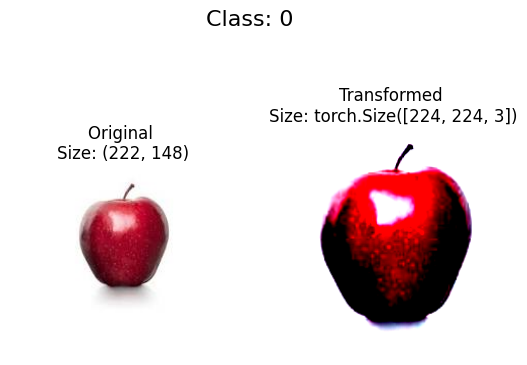

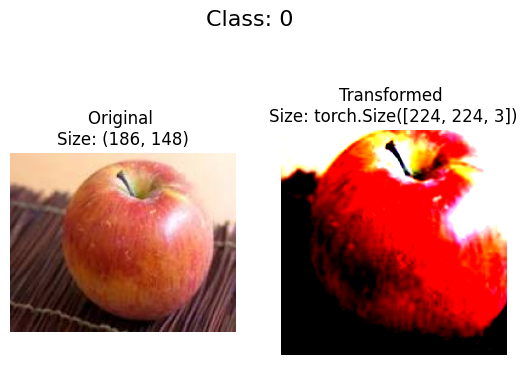

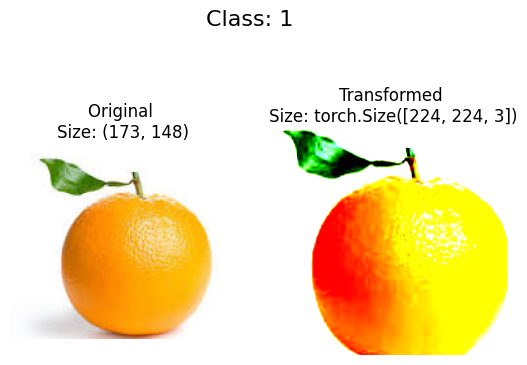

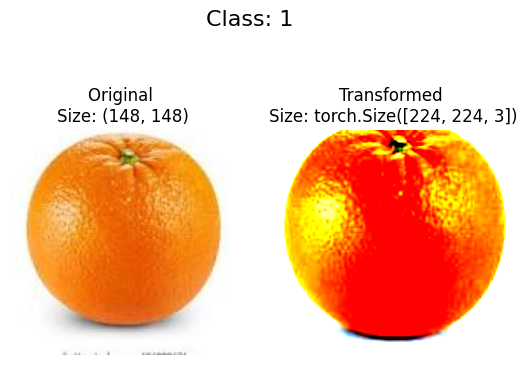

In [3]:
def plot_transformed_images(image_paths, labels, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    for idx, image_path in enumerate(image_paths):
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {labels[idx]}", fontsize=16)

paths, labels = zip(*dataset.samples)
plot_transformed_images(paths, labels,
                         transform=transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ]), n=3)

In [4]:
img, label = dataset[0][0], dataset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


## Loading Data from a CSV file for Deep Learning

In [5]:
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


`__init__ `

- Things that are constant, or things we may need to initialize once. For example, the path to the dataset, or the transform we want to apply to the data.

- Store information such as the paths to your data files

`__len__`

- Each call requests a sample index for which the upperbound is specified by the `__len__` method.

`__getitem__`

- Then the generator executes the `__getitem__` method to get the data for that index. 

In [6]:
class StudentsPerformanceDataset(Dataset):
    """Students Performance dataset."""

    def __init__(self, csv_file):
        """Initializes instance of class StudentsPerformanceDataset.
        Args:
            csv_file (str): Path to the csv file with the students data.
        """
        df = pd.read_csv(csv_file)

        # Grouping variable names
        self.categorical = ["gender", "race/ethnicity", "parental level of education", "lunch",
                           "test preparation course"]
        self.target = "math score"

        # One-hot encoding of categorical variables
        self.students_frame = pd.get_dummies(df, columns=self.categorical)

        self.X = self.students_frame.drop(self.target, axis=1)
        self.y = self.students_frame[self.target]

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.students_frame)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        # Ensure the data is in float32 numpy array format before conversion to tensor
        X_values = self.X.iloc[idx].values.astype('float32')  # Convert to float32 numpy array
        y_value = float(self.y.iloc[idx])  # Ensure y is a float
        
        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X_values, dtype=torch.float)
        y_tensor = torch.tensor(y_value, dtype=torch.float)
        
        return X_tensor, y_tensor

In [7]:
students_dataset = StudentsPerformanceDataset('/projectnb/ds598/materials/datasets/misc/StudentsPerformance.csv')
print(students_dataset[0])

(tensor([72., 74.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.]), tensor(72.))


## When you have your Dataset as a Directory

Can still use `torchvision.datasets.ImageFolder` to load the data. But if you want more fine grained control over the data, you can create your own custom dataset.

In [8]:
'''
Example Folder Structure:

Landmark_Images/
├── train/
│   ├── 00_classname/
│   │   ├── 00_image.jpg
│   │   ├── 01_image.jpg
│   │   └── ...
│   ├── 01_classname/
│   │   ├── 00_image.jpg
│   │   ├── 01_image.jpg
│   │   └── ...
│   └── ...
└── test/
    ├── 00_classname/
    │   ├── 00_image.jpg
    │   ├── 01_image.jpg
    │   └── ...
    ├── 01_classname/
    │   ├── 00_image.jpg
    │   ├── 01_image.jpg
    │   └── ...
    └── ...
'''

train_data_path = '/projectnb/ds598/materials/datasets/landmark_images/train'
test_data_path = '/projectnb/ds598/materials/datasets/landmark_images/test'

In [9]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(train_data_path)

There are 50 directories and 0 images in '/projectnb/ds598/materials/datasets/landmark_images/train'.
There are 0 directories and 100 images in '/projectnb/ds598/materials/datasets/landmark_images/train/11.Mount_Rushmore_National_Memorial'.
There are 0 directories and 100 images in '/projectnb/ds598/materials/datasets/landmark_images/train/30.Brooklyn_Bridge'.
There are 0 directories and 100 images in '/projectnb/ds598/materials/datasets/landmark_images/train/19.Vienna_City_Hall'.
There are 0 directories and 100 images in '/projectnb/ds598/materials/datasets/landmark_images/train/48.Whitby_Abbey'.
There are 0 directories and 100 images in '/projectnb/ds598/materials/datasets/landmark_images/train/21.Taj_Mahal'.
There are 0 directories and 100 images in '/projectnb/ds598/materials/datasets/landmark_images/train/36.Badlands_National_Park'.
There are 0 directories and 100 images in '/projectnb/ds598/materials/datasets/landmark_images/train/40.Stockholm_City_Hall'.
There are 0 directories 

### We now get the paths to the images in the dataset, and then use the paths to load the images into memory, when required.

In [10]:
train_image_paths = [] #to store image paths in list
classes = [] #to store class values

for data_path in glob.glob(train_data_path + '/*'): # glob.glob returns list of paths matching the pathname pattern (/* means all files in the directory)
    classes.append(data_path.split('/')[-1]) # taking the file name from the path and appending to classes list
    train_image_paths.extend(glob.glob(data_path + '/*')) # adding all the image paths to train_image_paths list
    
print(len(train_image_paths))
random.shuffle(train_image_paths)

#split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]


4996


In [11]:
print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])


train_image_path example:  /projectnb/ds598/materials/datasets/landmark_images/train/29.Petronas_Towers/7ad03d688c1bec95.jpg
class example:  11.Mount_Rushmore_National_Memorial


Random image path: /projectnb/ds598/materials/datasets/landmark_images/train/18.Delicate_Arch/5b76a3f030d59eab.jpg
Image height: 600
Image width: 800


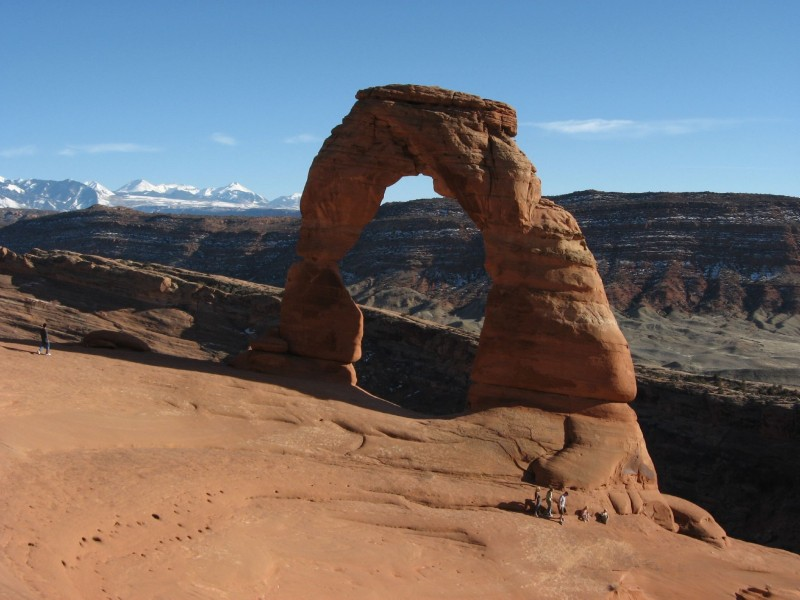

In [12]:
import random
from PIL import Image

random.seed(42)
random_image_path = random.choice(train_image_paths)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [13]:
# Similarly, we do the same for test data
test_image_paths = [] #to store image paths in list
test_classes = [] #to store class values

for data_path in glob.glob(test_data_path + '/*'):
    test_classes.append(data_path.split('/')[-1])
    test_image_paths.extend(glob.glob(data_path + '/*'))


In [15]:
print("\nTrain size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


Train size: 3996
Valid size: 1000
Test size: 1250


## Mapping the folder names to the class labels

In [16]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()} 
# The DL Model predicts the most likely index, we then use this dict to convert the index to class name

idx_to_class

{0: '11.Mount_Rushmore_National_Memorial',
 1: '30.Brooklyn_Bridge',
 2: '19.Vienna_City_Hall',
 3: '48.Whitby_Abbey',
 4: '21.Taj_Mahal',
 5: '36.Badlands_National_Park',
 6: '40.Stockholm_City_Hall',
 7: '00.Haleakala_National_Park',
 8: '31.Washington_Monument',
 9: '10.Edinburgh_Castle',
 10: '45.Temple_of_Heaven',
 11: '23.Externsteine',
 12: '49.Temple_of_Olympian_Zeus',
 13: '03.Dead_Sea',
 14: '33.Sydney_Opera_House',
 15: '42.Death_Valley_National_Park',
 16: '15.Central_Park',
 17: '44.Trevi_Fountain',
 18: '38.Forth_Bridge',
 19: '47.Prague_Astronomical_Clock',
 20: '27.Seattle_Japanese_Garden',
 21: '16.Eiffel_Tower',
 22: '04.Wroclaws_Dwarves',
 23: '41.Machu_Picchu',
 24: '14.Terminal_Tower',
 25: '08.Grand_Canyon',
 26: '37.Atomium',
 27: '13.Yellowstone_National_Park',
 28: '46.Great_Wall_of_China',
 29: '07.Stonehenge',
 30: '09.Golden_Gate_Bridge',
 31: '35.Monumento_a_la_Revolucion',
 32: '02.Ljubljana_Castle',
 33: '20.Matterhorn',
 34: '34.Great_Barrier_Reef',
 35:

In [17]:
#######################################################
#               Define Dataset Class
#######################################################

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [18]:
####################################################
#                Define parameters
####################################################

params = {
#    "model": "resnet50",
    #"device": "cuda",
#    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "n_epochs": 10,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 5
}

### Check out albumentations for some decent image augmentations (https://albumentations.ai)

In [19]:
import torchvision
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=params["image_size"], width=params["image_size"]),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=params["image_size"], width=params["image_size"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [20]:
train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

In [21]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  (256, 256, 3)
The label for 50th image in train dataset:  47


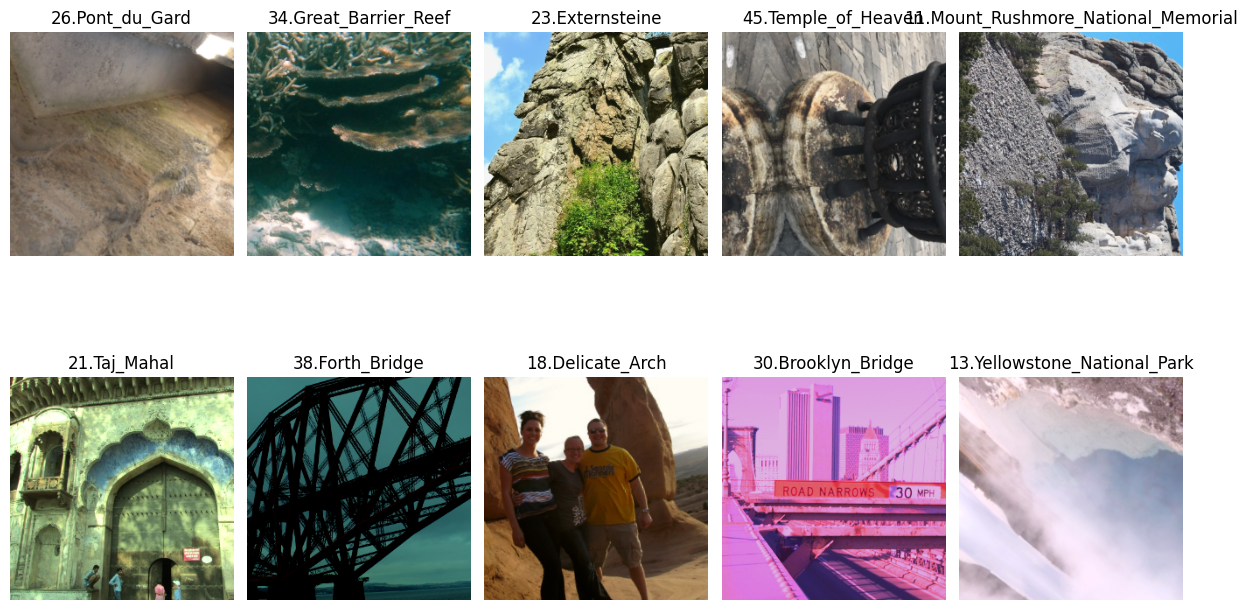

In [22]:
import copy
#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [23]:
print(len(train_dataset))

3996


# Loading the Data

![image](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ZNHDlhNnAFTsQwxJHteqUA.png)

In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
            train_dataset, # The samples in our dataset
            batch_size=16, # How many samples per batch to load
            shuffle=False, # Whether to shuffle the samples
            num_workers=4, # Number of cores that are used to prepare the batches (in parallel). 
        )

In [25]:

for i, (data, target) in enumerate(train_loader):
    print(data.shape)
    print(target)
    break

torch.Size([16, 256, 256, 3])
tensor([41,  6, 49, 33, 47, 48, 46, 11,  7, 24, 14, 32, 31,  4, 39,  3])


In [26]:
nlp_data = [
    {'tokenized_input': [1, 4, 5],
     'label':0},
    {'tokenized_input': [1, 7, 3],
     'label':0},
    {'tokenized_input': [1, 30, 67],
     'label':1},
    {'tokenized_input': [1, 17, 2],
     'label':0},
]
loader = DataLoader(nlp_data, batch_size=2, shuffle=False)
batch = next(iter(loader))
print(f'input: {batch["tokenized_input"]}')
print(f'label: {batch["label"]}')

input: [tensor([1, 1]), tensor([4, 7]), tensor([5, 3])]
label: tensor([0, 0])


In [29]:
nlp_data = [
    {'tokenized_input': [1, 4, 5, 9, 3, 2],
     'label':0},
    {'tokenized_input': [1, 7, 3, 14, 48, 7, 23, 154, 2],
     'label':0},
    {'tokenized_input': [1, 30, 67, 117, 21, 15, 2],
     'label':1},
    {'tokenized_input': [1, 17, 2],
     'label':0},
]
loader = DataLoader(nlp_data, batch_size=2, shuffle=False)
batch = next(iter(loader))

RuntimeError: each element in list of batch should be of equal size

### What Caused the Error?

DataLoader stacks Torch Tensors in a batch. If the tensors are of different sizes, Pytorch would be unable to stack them into a batch (as the dimensions would not match). 

#### Easy Fix: 
Pad the tokens to the Max Length of tokens in the 'Entire Dataset' (A lot of wasted memory, and time.)

#### Better Fix: 
Pad the tokens to the Max Length of the tokens in the **'Batch'**

In [30]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate(data):
    inputs = [torch.tensor(d['tokenized_input']) for d in data]
    labels = [d['label'] for d in data]

    inputs = pad_sequence(inputs, batch_first=True)
    labels = torch.tensor(labels)

    return {
        'tokenized_input': inputs,
        'label': labels
    }

In [31]:
loader = DataLoader(nlp_data, batch_size=2, 
shuffle=False, collate_fn=custom_collate) # Explicitly Tell DataLoader how to stack the data

iter_loader = iter(loader)
batch1 = next(iter_loader)
print(batch1, batch1['tokenized_input'].shape)
batch2 = next(iter_loader)
print(batch2, batch2['tokenized_input'].shape)

{'tokenized_input': tensor([[  1,   4,   5,   9,   3,   2,   0,   0,   0],
        [  1,   7,   3,  14,  48,   7,  23, 154,   2]]), 'label': tensor([0, 0])} torch.Size([2, 9])
{'tokenized_input': tensor([[  1,  30,  67, 117,  21,  15,   2],
        [  1,  17,   2,   0,   0,   0,   0]]), 'label': tensor([1, 0])} torch.Size([2, 7])


## Object Detection

A very low-level introduction to Object Detection.

![image](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/bc1.PNG)

![title](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/jaccard.jpg)

![title](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/ecs1.PNG)

Considering we use 8732 of such priors, at the model output, the model will predict the regressed values for each of the priors, and the class scores for each of the priors.

![title](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/reshaping2.jpg)

### Loss Formulation

The network has 2 tasks:
* Predict the class of the object
* Predict the bounding box of the object

Thereby, the loss is an aggregate of the losses from both the tasks.

![title](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/matching1.PNG)

We then match the priors against each GT box, and assign the priors with the highest IoU to the GT box.

![title](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/matching2.jpg)

* Predictions that have a matched set of GT coordinates will serve as targets for Localization (regression task)
* Predictions that have a matched set of GT class labels will serve as targets for Class Prediction (classification task)

So the Loss formulation ends up being something like this:

#### Loss = Localization Loss + alpha * Classification Loss

![title](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/nms1.PNG)

![title](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/nms2.PNG)

![title](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/nms3.jpg)

### References:
https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection    
https://averdones.github.io/reading-tabular-data-with-pytorch-and-training-a-multilayer-perceptron/